# Import

In [1]:
# extensions for jupyter notebook
#reload install packages w/o restartting kernel
%load_ext autoreload 
%autoreload 2
#plots display in the cell
%matplotlib inline
%config InlineBackend.figure_format = 'png'
#faster autocompletion
%config IPCompleter.use_jedi = False 

# data analysis packages
import pandas as pd
import numpy as np

# plotting packages & params for figures
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.dpi'] = 120

import warnings
warnings.filterwarnings('ignore')

In [2]:
from functions.utils import read_dataset, median_scale, predict_batch
from functions.feature_calc import naming_mapper, gmt_genes_alt_names, ssgsea_formula, run_progeny

import pickle
print(pickle.format_version)

4.0


In [3]:
# Progress bar visualization
from tqdm import tqdm

In [4]:
def get_batch_and_predicitons_for_samples(sample_df, ref_df, batch, k=100):
    batch_pred = {}
    probas = {}
    sc_feats = []
    
    for name, ser in tqdm(sample_df.iterrows()):
        
        ser = ser[(~ser.isna())] # Can't process NaN features
        
        X_ref = ref_df[ser.index].dropna() # Same set of features; be consious, classifier only take full set of features!
    
        ident_batch = predict_batch(ser, X_ref, batch, k=k) #Higher k will produce better results
        batch_pred[name] = ident_batch
    
        ref_coh = X_ref[batch==ident_batch]
        
        scaled_features = median_scale(pd.concat([ref_coh,ser.to_frame().T])) #concat with identified cohort and scale
        scaled_features = scaled_features.loc[name]
        
        prob = model.predict_proba(scaled_features.to_frame().T)
        probas[name] = list(prob[0])

        sc_feats.append(scaled_features.to_frame())
    
    batch_pred = pd.Series(batch_pred)
    probas = pd.DataFrame(probas)
    probas.index = model.classes_ 
    
    probas.loc['Unclassified'] = 0
    probas.loc['Unclassified',probas.columns[probas[probas>0.47].isna().all()]] = 1 # Set threshold
    
    class_predict = probas.idxmax()

    sc_feats = pd.concat(sc_feats, axis=1).T
    
    return batch_pred, probas, class_predict, sc_feats

# Data

Prepare your sample according to the [guidelines](https://github.com/BostonGene/Immune_Escape/blob/main/DATA_AND_QC.md) (take required transcripts, perform QC), then load: 

In [5]:
cohort_name = 'QC_example_SKCM_HugoMAPK2_GSE75313'

expression = read_dataset('test_data/QC_example_SKCM_HugoMAPK2_GSE75313/output/expressions_refined.tsv.gz')
expression.head()

,SRX1446796,SRX1446797,SRX1446798,SRX1446799,SRX1446800,SRX1446801,SRX1446802,SRX1446803,SRX1446804,SRX1446805,SRX1446808,SRX1446809,SRX1446810,SRX1446811,SRX1446812,SRX3173615,SRX3173616,SRX3173617
Gene,,,,,,,,,,,,,,,,,,
A1BG,0.000000,0.000000,0.073078,0.046100,0.000000,0.000000,0.031377,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.360252,0.125111,0.000000,0.185589
A1CF,0.000000,0.000000,0.016818,0.032895,0.018860,0.030272,0.020603,0.018773,0.015271,0.003989,0.027835,0.018157,0.042922,0.018590,0.000000,0.081888,0.052673,0.071418
A2M,8.315325,8.688029,7.213757,8.189954,9.775147,9.202142,8.738409,8.469137,9.093775,10.379255,8.937630,9.948894,8.181539,8.152129,8.168005,7.846306,8.958495,9.082054
A2ML1,1.939184,3.383156,5.002732,5.324455,0.676129,0.108234,1.979346,1.943242,0.596630,0.193554,0.180695,0.083906,0.308971,0.130943,0.519393,3.735812,0.518568,4.607811
A3GALT2,0.000000,0.080243,0.000000,0.000000,0.800559,0.293649,0.000000,0.029331,0.000000,0.000000,0.000000,0.705637,0.000000,0.061043,0.476854,0.786077,0.556590,0.659706


In [6]:
# Load gmt and progeny coefficients from pickle

with open('model/IE_clusters.pickle', 'rb') as f:
    ie_dict = pickle.load(f)

feature_list = ie_dict['X'].columns.to_list()

gmt = ie_dict['gmt_dict']
gmt = gmt_genes_alt_names(gmt, expression.index, verbose=True)

prog_coeffs = ie_dict['progeny_coeffs'].reset_index()

Matched: 356
Trying to find new names for 1 genes in 19706 known


1 input query terms found dup hits:	[('TRBC1', 2)]


1 genes were not converted


## Load metacohort for mapping

In [7]:
# Raw features -- unscaled scores; sc features -- scaled scores.
raw_features_meta = read_dataset('data/Metacohort_full_unscaled_features.tsv.gz').rename(columns=naming_mapper)[feature_list+['Batch']]
sc_features_meta = read_dataset('data/Metacohort_full_scaled_features.tsv.gz').rename(columns=naming_mapper)[feature_list+['Batch']]
ie_class_meta = read_dataset('data/Metacohort_full_class_prediction.tsv.gz', usecols=[0,11]).ie_class

# Calculate features

Load FGES and PROGENy coefficients; calculate features.

In [8]:
# Calculate ssgsea
ssgsea_df = ssgsea_formula(expression.T, gmt)

# Calculate progeny
progen_df = run_progeny(expression, prog_coeffs=prog_coeffs).T

In [9]:
#Concat
features_df = pd.concat([ssgsea_df, progen_df], axis=1)[feature_list]

features_df.head()

,Metabolic suppression of CTL,B cells,M1 cytokines,Treg cells,pDC,T cells,TLS_NL,Anti-tumor chemokines,Lymphoid_checkpoints,NK cells,...,Adipocytes,EGFR,MAPK,Hypoxia,Hypoxia_factors,Glycolysis,PI3K,Autophagy,Acidosis,Proliferation_rate
SRX1446796,3985.709952,-3884.138774,-1648.754375,-1769.612829,-79.245004,460.102859,1271.504103,2650.380093,-2279.968697,-2938.296899,...,-1026.297588,239.865412,719.737279,2919.926211,4801.965360,8145.301327,-1808.919072,5591.446739,3654.723778,4841.753306
SRX1446797,5174.958890,-3679.885859,-503.270988,-1323.023632,-947.570186,1571.705614,1366.566097,2471.748880,-2471.442183,-1914.812690,...,-1053.543692,68.943058,390.370477,2940.539383,5350.730203,7996.579165,-1717.763551,6263.916348,2582.211411,1351.137509
SRX1446798,2869.289496,-5196.271912,-2234.337666,-946.301099,-1680.457667,1430.556387,1499.660210,1689.882960,-2970.227740,-3330.854164,...,-3270.155298,207.712098,676.063867,3311.090882,5740.752062,8116.339947,-1850.359166,5676.118638,4725.338139,4604.241679
SRX1446799,3467.957320,-3947.158683,-3035.724010,-749.844071,-2566.339720,1142.469852,33.260150,744.416670,-4088.191395,-3783.843105,...,-1505.496207,22.902882,460.304813,3251.027969,6181.541590,7762.469580,-1682.728968,6147.326850,2704.519121,1936.318944
SRX1446800,2969.759781,-2739.281849,443.245442,-2955.165535,-1287.810252,-1498.351958,1581.599926,2986.897478,-3513.056746,-3056.053696,...,-2488.350161,127.799120,840.808627,3472.956247,5236.563707,7820.668200,-1991.965620,6056.842810,5578.752045,2666.941984


# Find reference, scale and classify

Load model, map samples to metacohort, scale and classify

In [10]:
# Load pre-treained model
with open('model/ovr_knn_calibrated.pickle', 'rb') as f:
    model = pickle.load(f)

In [11]:
# Define variables
sample_df = features_df
ref_df = raw_features_meta

batch = ref_df['Batch']
ref_df = ref_df.drop(columns='Batch')

# Run prediction
batch_pred, probas, class_predict, sc_feats = get_batch_and_predicitons_for_samples(sample_df, ref_df, batch, k=10)

18it [00:01, 13.00it/s]


In [12]:
class_predict.to_csv('test_data/QC_example_SKCM_HugoMAPK2_GSE75313/output/class_prediction_identified_batch_scaling.tsv', sep='\t')
batch_pred.to_csv('test_data/QC_example_SKCM_HugoMAPK2_GSE75313/output/identified_batch.tsv', sep='\t')

# Visualize

In [13]:
from functions.plotting import *

## Prediction results

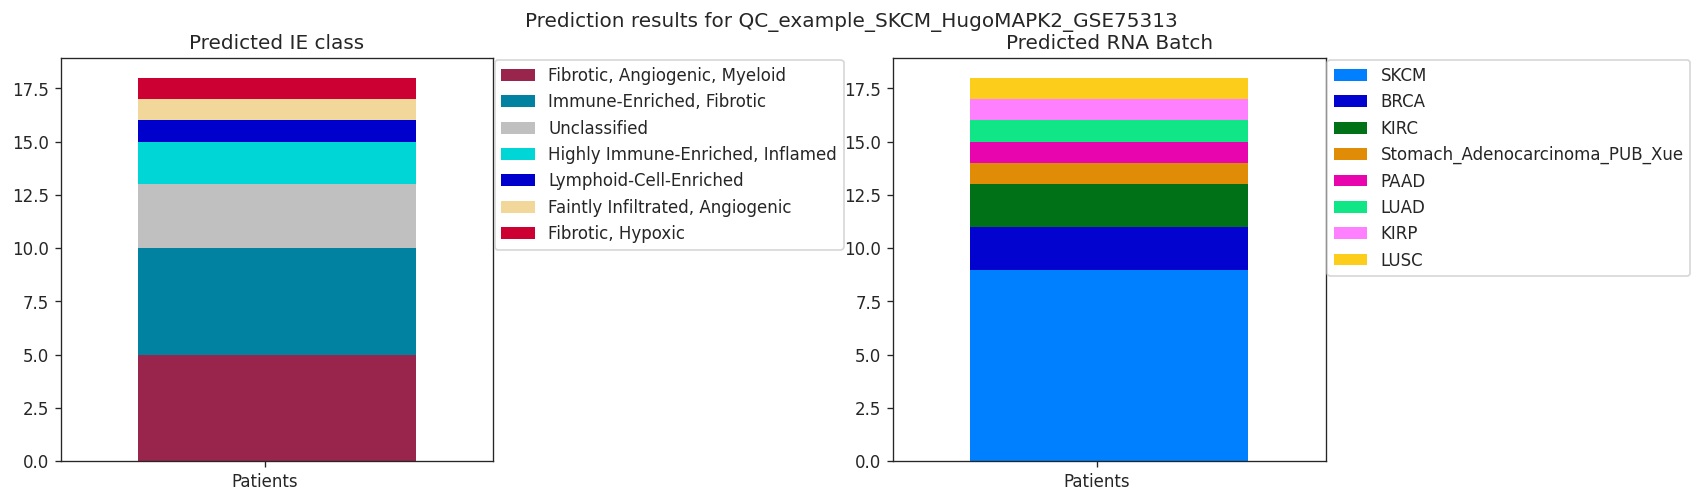

In [14]:
af = axis_net(2, 1, title = f'Prediction results for {cohort_name}', x_len=7)

plot_data = class_predict.value_counts().to_frame().T
plot_data.index = ['Patients']

ax = next(af)
bot_bar_plot(plot_data, palette=ie_palette, ax=ax)
ax.set_title('Predicted IE class')

pal = palette_from_series(batch_pred)

plot_data = batch_pred.value_counts().to_frame().T
plot_data.index = ['Patients']

ax = next(af)
bot_bar_plot(plot_data, palette=pal, ax=ax)
ax.set_title('Predicted RNA Batch')

plt.tight_layout(pad=0.05)

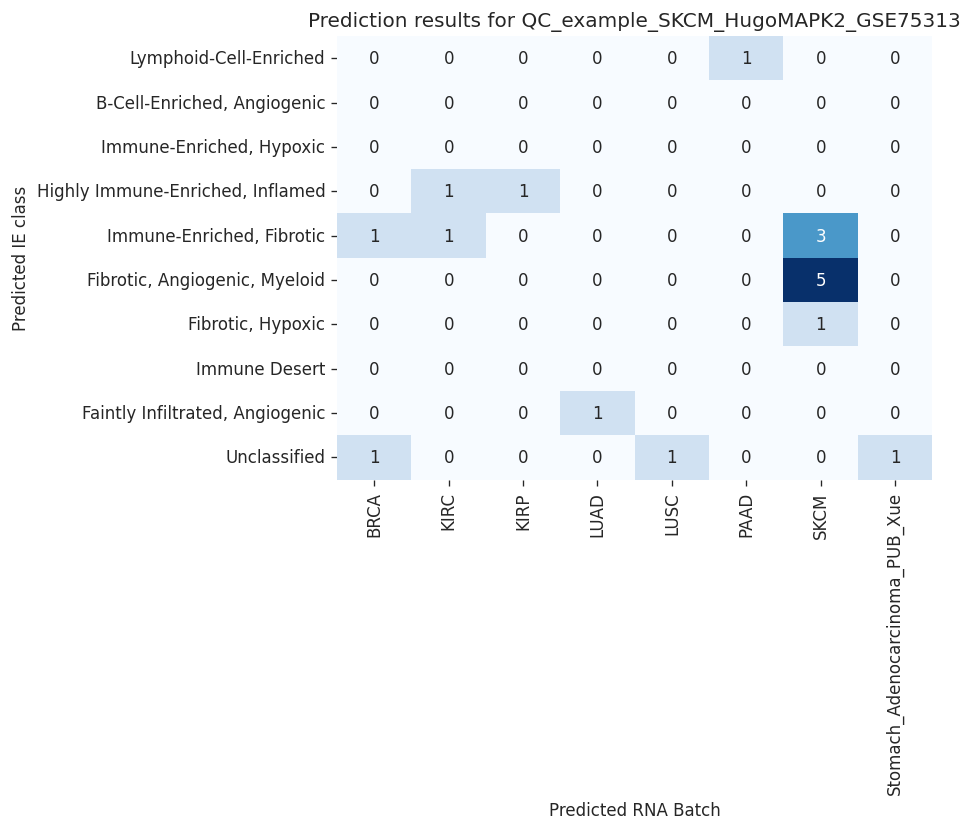

In [15]:
sns.heatmap(pd.crosstab(class_predict, batch_pred).reindex(ie_order+['Unclassified']).fillna(0), cmap='Blues', annot=True, fmt='.0f', cbar=False)
plt.xlabel('Predicted RNA Batch')
plt.ylabel('Predicted IE class')
_ = plt.title(f'Prediction results for {cohort_name}')

## Metacohort mapping

In [16]:
def highlight_predicted_samples(c_grouping, data_tr, pal, ax, label_samples=True, s=20):

    ind = c_grouping.index&data_tr.index
    data = data_tr.loc[ind]
    
    texts = [] if label_samples else None
    X = []
    Y = []
    
    for name, row in data.iterrows():
        x, y = row.loc[0], row.loc[1]
        c_color = pal[c_grouping.loc[name]]

        ax.scatter(x, y, color=c_color, s=s, edgecolors='black')

        if label_samples:
            texts.append(ax.text(x, y, s=str(name), fontsize=7, bbox=dict(facecolor='white', boxstyle='round,pad=0.01', alpha=0.4)))
        
        X.append(x)
        Y.append(y)

    if label_samples:
        adjust_text(
            texts, x=X, y=Y, arrowprops=dict(arrowstyle='-', color='black', lw=1), ax=ax
        )

In [25]:
def dr_plots(labels, pal, label_samples=True, cohort_s = 20):
    af = axis_net(2, 1, title = f'Mapping {cohort_name}, N={N_coh} to {N_metacoh} cohort\n{len(feature_list)} MAD-scaled feature space', x_len=7)

    ax= next(af)
    _, data_tr_pca, model_pca = pca_plot(plot_df, labels, title=f"PCA, linear and robust", ax=ax, legend=False, s=2, palette=pal, return_model=True)
    
    highlight_predicted_samples(labels.loc[cohort_labels.index], data_tr_pca, pal, ax=ax, label_samples=label_samples, s=cohort_s)
    
    ax= next(af)
    _, data_tr_umap, model_umap = umap_plot(plot_df, labels, title=f"UMAP, nicer visualization", ax=ax, legend='out', s=2, palette=pal, return_model=True)
    
    highlight_predicted_samples(labels.loc[cohort_labels.index], data_tr_umap, pal, ax=ax, label_samples=label_samples, s=cohort_s)
    
    plt.tight_layout(pad=0.1)

In [26]:
plot_df = pd.concat([sc_features_meta, sc_feats]).iloc[:,:-1].clip(-4,4)

N_metacoh = len(sc_features_meta)
N_coh = len(sc_feats)

In [27]:
cohort_labels = pd.Series(index=sc_feats.index, data=[cohort_name]*N_coh)
cohort_type_labels = pd.concat([pd.Series(index=sc_features_meta.index, data=['Metacohort']*N_metacoh), cohort_labels])

coh_palette = {'Metacohort':'lightgray', cohort_name:'crimson'}

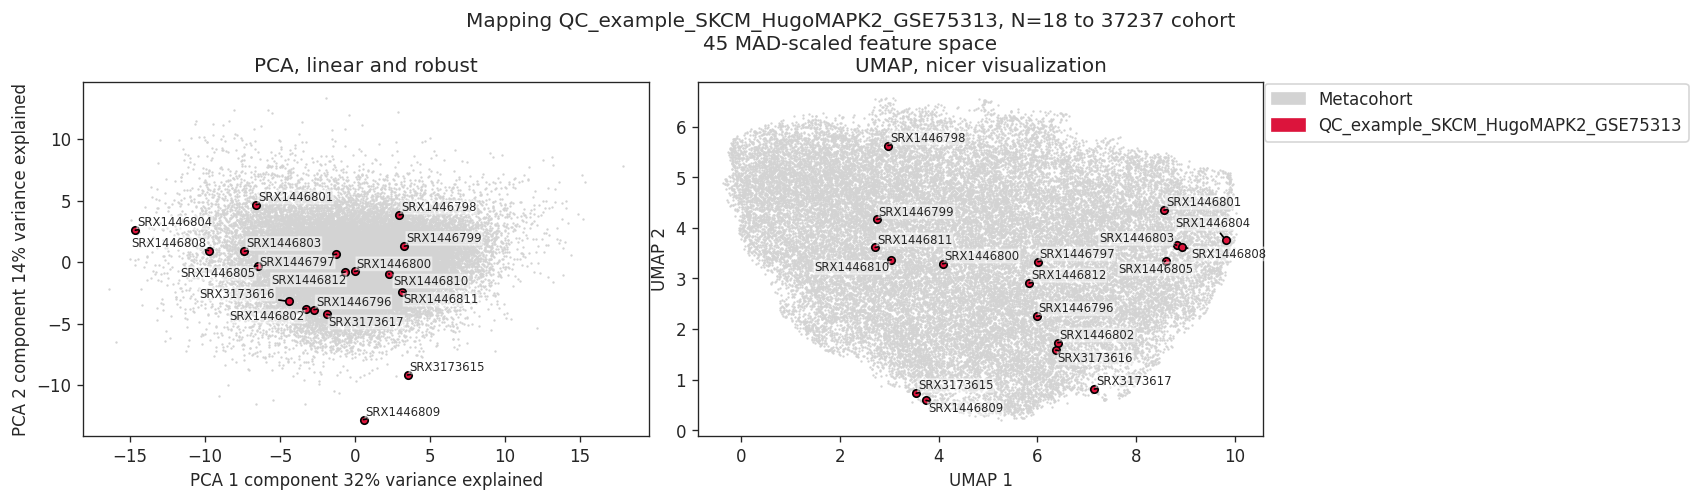

In [28]:
labels, pal = cohort_type_labels, coh_palette
dr_plots(labels, pal, label_samples=True)

In [29]:
batch_labels = pd.concat([sc_features_meta.Batch, batch_pred])
batch_labels.loc[~batch_labels.isin(batch_pred)] = 'Other'

batch_pal = palette_from_series(batch_labels)
batch_pal['Other'] = 'lightgray'

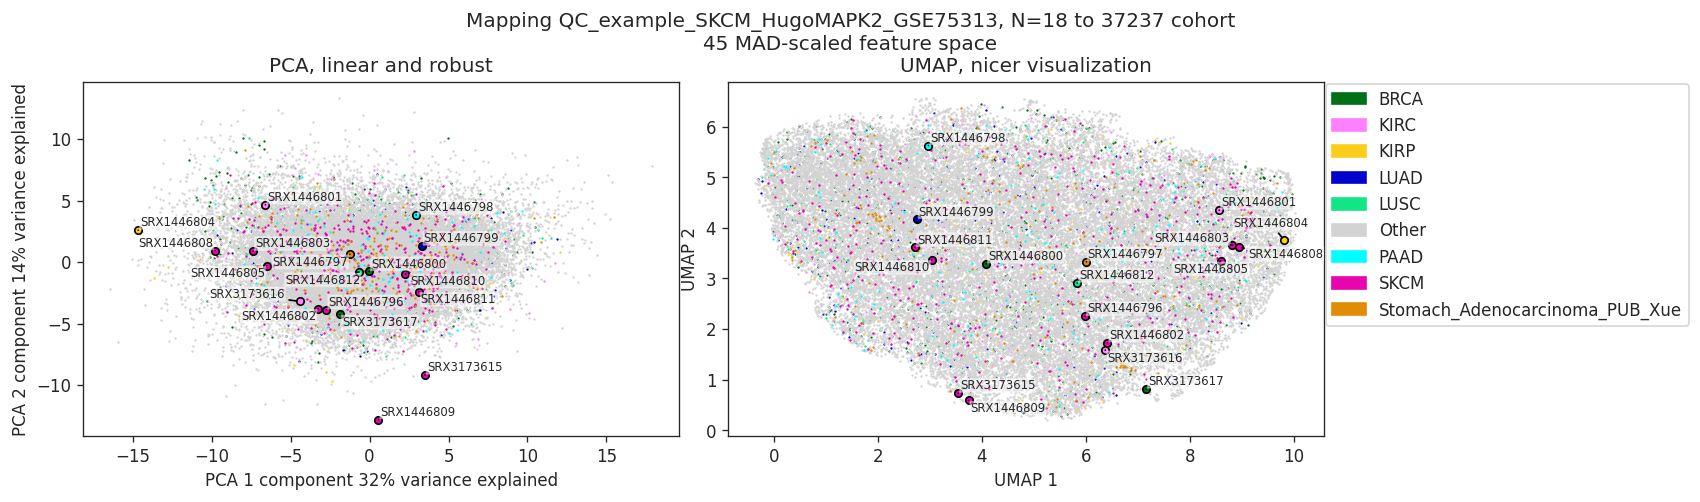

In [30]:
labels, pal = batch_labels, batch_pal
dr_plots(labels, pal, label_samples=True)

In [31]:
class_labels = pd.concat([ie_class_meta, class_predict])

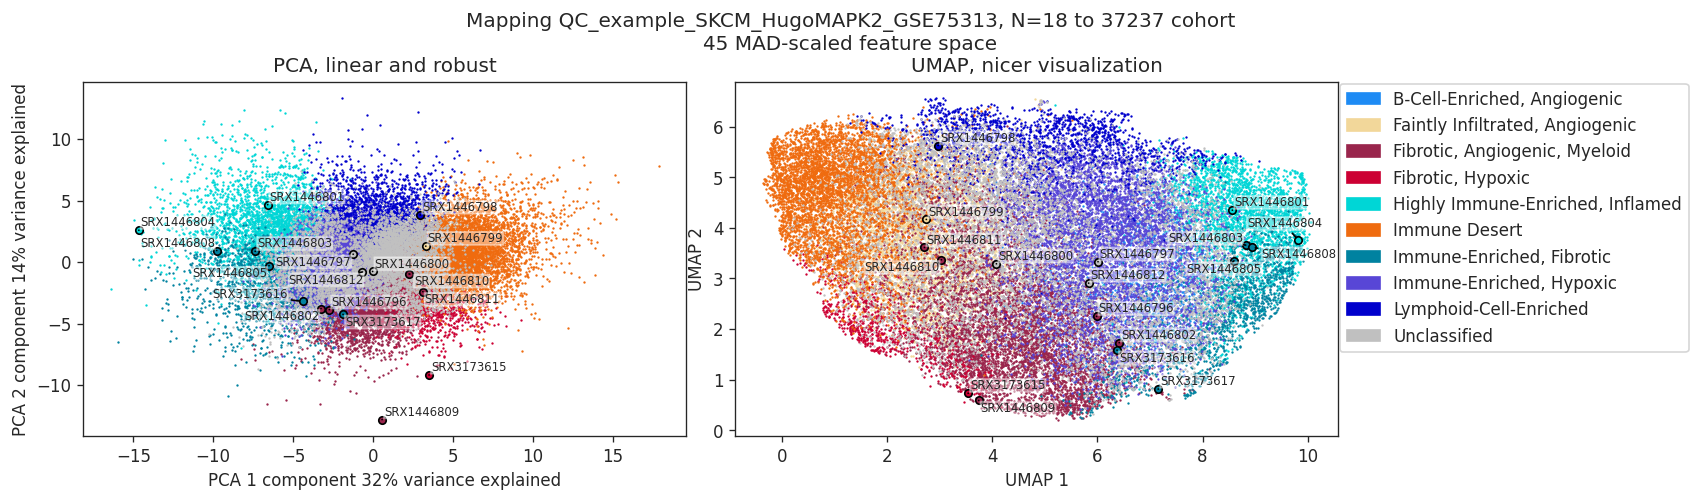

In [32]:
labels, pal = class_labels, ie_palette
dr_plots(labels, pal, label_samples=True)